In [1]:
import readligo as rl
import numpy as np

fn_H1 = r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroGW\GW-signals\H-H1_LOSC_4_V1-1126259446-32.hdf5'
NR_H1 = r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroGW\GW-signals\GW150914_4_NR_waveform.txt'
strain, time, chan_dict = rl.loaddata(fn_H1, 'H1')
NRtime, NR_H1 = np.genfromtxt(NR_H1).transpose()


In [2]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

time = time[indxt]
strain = strain[indxt]

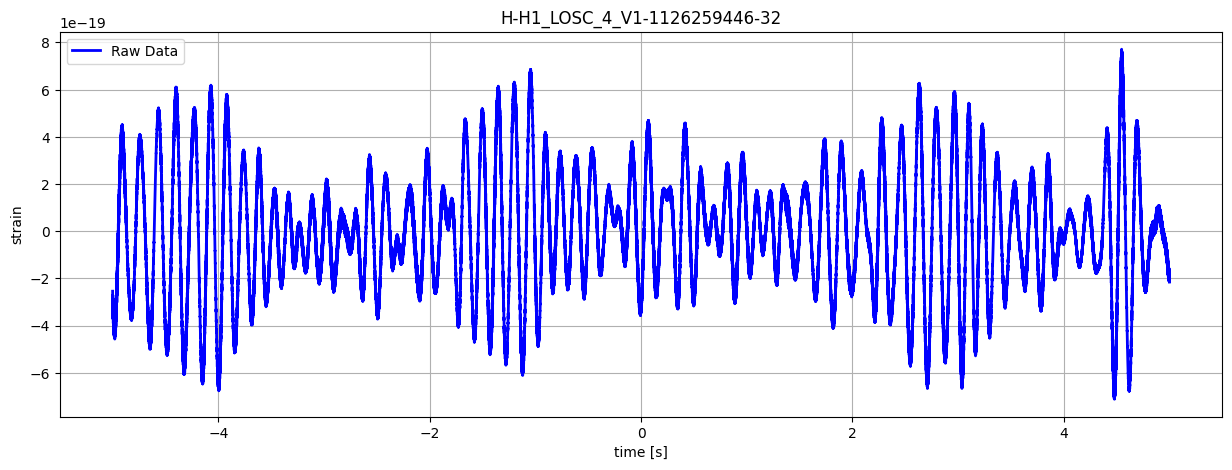

In [3]:
import matplotlib.pyplot as plt

fig, _ = plt.subplots(figsize=(15,5))
plt.plot(time- tevent,strain, label='Raw Data', color='blue', linewidth=2)
plt.xlabel('time [s]')
plt.ylabel('strain')
plt.grid()
plt.title(r'H-H1_LOSC_4_V1-1126259446-32')
#plt.text(-.5,5.1*1e-21, r"$m_{1}=37 M_{\odot}$, $m_{2}=40M_{\odot}$ , D = 100MPc", fontsize=14)
plt.legend()

We have to clean our data.\
First we compute the Power Spectral Density (PSD) of the signal

In [4]:
from matplotlib import mlab
from scipy.interpolate import interp1d
import numpy as np

fs = 4096
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx, freqs = mlab.psd(strain, Fs = fs, NFFT = NFFT)

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

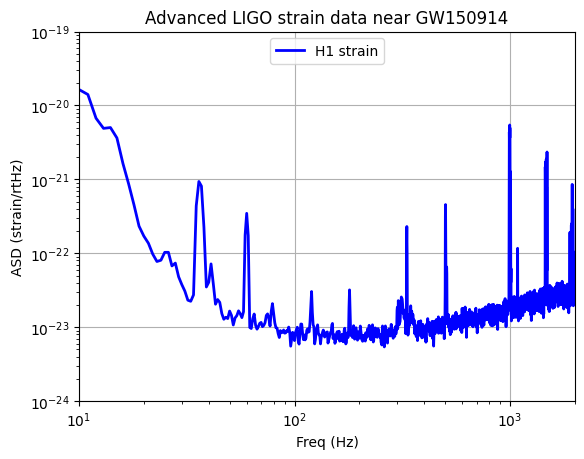

In [5]:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx),'b',label='H1 strain', linewidth=2)
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title("Advanced LIGO strain data near GW150914")

As we can see we have some $\frac{1}{f}$ noise.\
Our signal (if it's there is well hidden by noise)
The minimum frequency is $10 \text{Hz}$ since the LIGO detector is not calibrated under this frequency.\
Also the maximum frequency is determined by the Nyquist theorem ehich poses an upper bound to the frequency we can afford to examine, half the sampling frequency $f_{\text{max}} = \frac{1}{2} f_{\text{sampling}}$\
The peaks present in the ASD are probably due to detector noise.\
We can now try to whiten our data.

In [6]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt) # returns frequencies of fourier transform 
    hf = np.fft.rfft(strain) # returns frequencies amplitudes of fourier transform 
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

psd = interp1d(freqs, Pxx)

# now whiten the data from H1 and L1, and also the NR template:
dt = time[1] - time[0]
strain_whiten = whiten(strain,psd,dt)
NR_H1_whiten = whiten(NR_H1,psd,dt)

In [8]:
from scipy.signal import butter, filtfilt

bb, ab          = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)
NR_H1_whitenbp  = filtfilt(bb, ab, NR_H1_whiten)

Text(0.5, 1.0, 'Whiten data near GW150914')

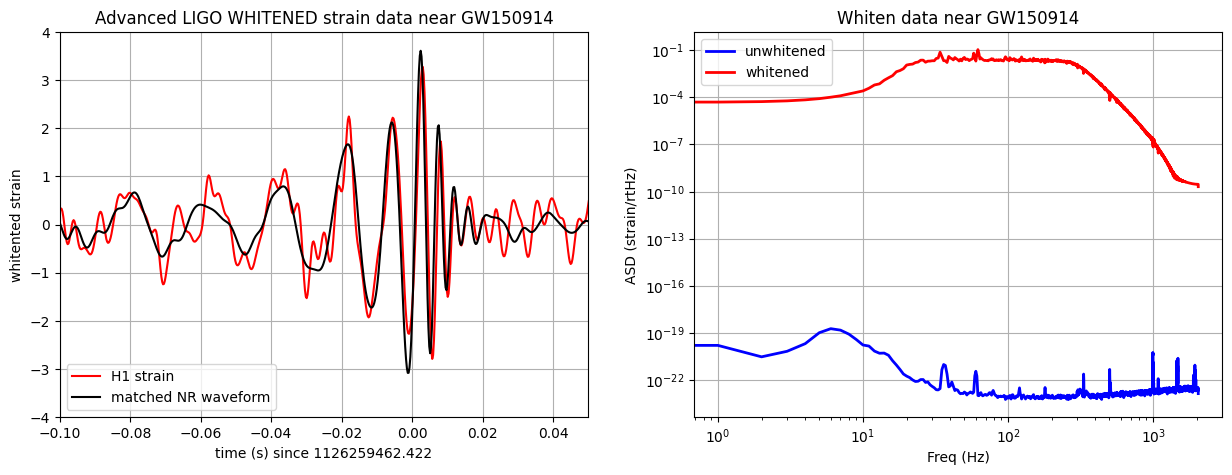

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(time-tevent,strain_whitenbp,'r',label='H1 strain')
axs[0].plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
axs[0].axis([-0.1,0.05,-4,4])
axs[0].set_xlabel('time (s) since '+str(tevent))
axs[0].set_ylabel('whitented strain')
axs[0].legend(loc='lower left')
axs[0].set_title('Advanced LIGO WHITENED strain data near GW150914')
axs[0].grid()

Pxx_whiten, freqs_whiten = mlab.psd(strain_whitenbp, Fs = fs, NFFT = NFFT)

axs[1].loglog(freqs, np.sqrt(Pxx),'b',label='unwhitened', linewidth=2)
axs[1].loglog(freqs_whiten, np.sqrt(Pxx_whiten),'r',label='whitened', linewidth=2)
#axs[1].axis([fmin, fmax, 1e-24, 1e-19])
axs[1].grid('on')
axs[1].set_ylabel('ASD (strain/rtHz)')
axs[1].set_xlabel('Freq (Hz)')
axs[1].legend()
axs[1].set_title("Whiten data near GW150914")

In [12]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                    # seconds around the event

indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
NFFT = int(fs/8)
NOVL = NFFT-1
window = np.blackman(NFFT)

(np.float64(-10.0), np.float64(10.0), np.float64(0.0), np.float64(2000.0))

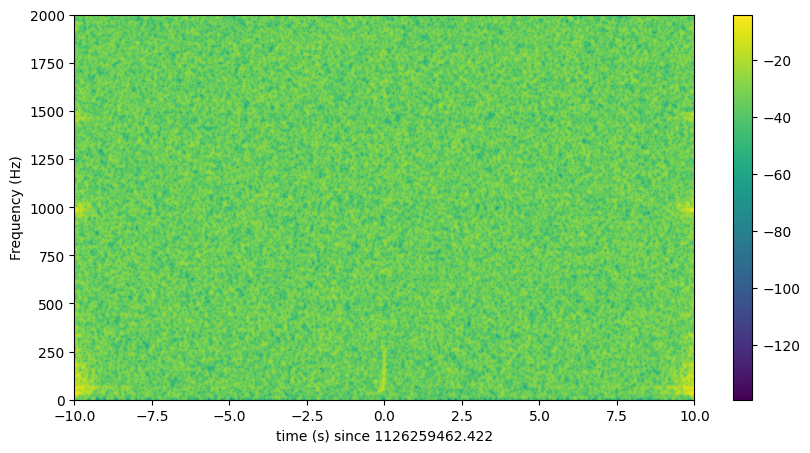

In [13]:
spec_cmap='viridis'
plt.figure(figsize=(10,5))
spec_H1, freqs, bins, im = plt.specgram(strain_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])

(np.float64(-0.5), np.float64(0.5), np.float64(0.0), np.float64(500.0))

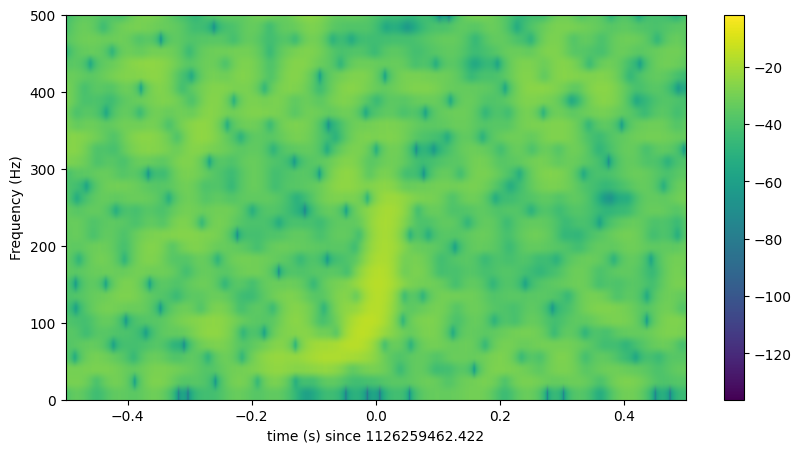

In [14]:
NFFT = int(fs/16)
NOVL = NFFT-1
window = np.blackman(NFFT)
plt.figure(figsize=(10,5))
spec_H1, freqs, bins, im = plt.specgram(strain_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])